In [24]:
import albumentations
from datasets import load_dataset
from torchvision.ops import box_convert
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer
import numpy as np
import torch
import os
from PIL import Image, ImageDraw
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [14]:
img_dataset = load_dataset('loader_script.py')

Found cached dataset loader_script (C:/Users/Authority/.cache/huggingface/datasets/loader_script/default/1.0.0/cd1c36562fe4155bf1234174bc6eb5c02887d8e021fcae47da930cc7f07c57ad)


  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
img_dataset['train'][0]

{'image_id': 6,
 'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGBA size=128x128>,
 'width': 128,
 'height': 128,
 'objects': {'id': [18],
  'area': [8248],
  'bbox': [[19.120332717895508,
    18.854772567749023,
    90.29045867919922,
    91.35269927978516]],
  'category': [4]}}

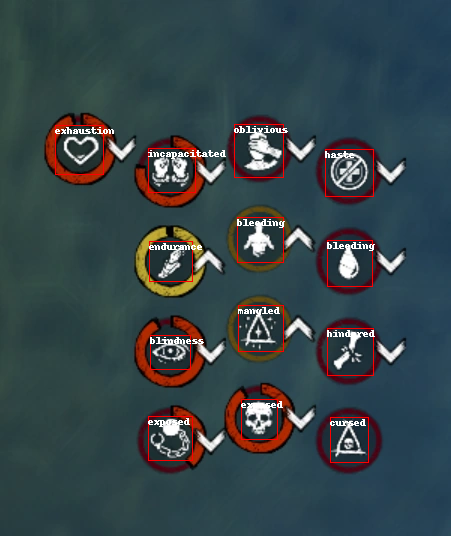

In [16]:
image = img_dataset['train'][21]['image']
annotations = img_dataset['train'][21]['objects']
draw = ImageDraw.Draw(image)

categories = img_dataset['train'].features['objects'].feature['category'].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations['id'])):
    box = annotations['bbox'][i - 1]
    class_idx = annotations['category'][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle([x, y, x + w, y + h], outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image

In [17]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
C:\Users\Authority\Desktop\dbdnet\venv\lib\site-packages\transformers\models\detr\image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [18]:
transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['category']))

In [19]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    return annotations

In [20]:
def transforms(examples):
    images, bboxes, categories = [], [], []
    for image, objects in zip(examples['image'], examples['objects']):
        image = np.array(image.convert('RGB'))[:, :, ::-1]
        out = transform(image=image, bboxes=objects['bbox'], category=objects['category'])
        images.append(torch.tensor(out['image']).flip(-1).permute(2, 0, 1))
        bboxes.append(torch.tensor(out['bboxes']))
        categories.append(out['category'])
    return {
        'image': images,
        'bbox': bboxes,
        'category': categories
    }

In [21]:
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {
            "image_id": image_id,
            "annotations": formatted_anns(image_id, category, area, bbox),
        }
        for image_id, category, area, bbox in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [22]:
transformed_train = img_dataset['train'].with_transform(transforms)

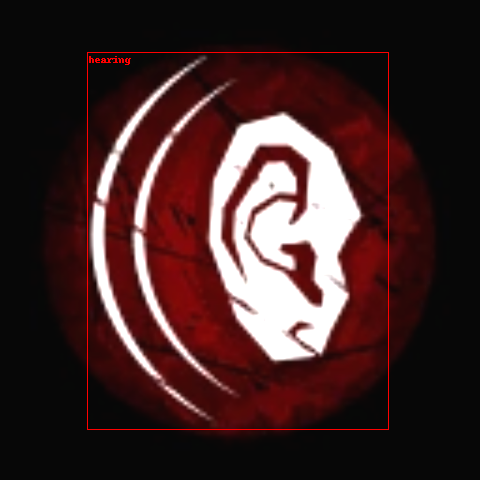

In [26]:
to_pil_image(
    draw_bounding_boxes(
        transformed_train[2]['image'],
        box_convert(transformed_train[2]['bbox'], 'xywh', 'xyxy'),
        colors='red',
        labels=[img_dataset['train'].features['objects'].feature['category'].int2str(x) for x in transformed_train[2]['category']]
    )
)

In [27]:
img_dataset['train'] = img_dataset['train'].with_transform(transform_aug_ann)


In [28]:
img_dataset['train'][15]

C:\Users\Authority\Desktop\dbdnet\venv\lib\site-packages\transformers\models\detr\image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-

In [29]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [30]:
model = AutoModelForObjectDetection.from_pretrained(checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([22, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([22]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
training_args = TrainingArguments(
    output_dir="coco_DBD_finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=25,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=img_dataset['train'],
    tokenizer=image_processor,
)


C:\Users\Authority\Desktop\dbdnet\coco_DBD_finetuned is already a clone of https://huggingface.co/lauralex/coco_DBD_finetuned. Make sure you pull the latest changes with `repo.git_pull()`.
Using cuda_amp half precision backend


In [33]:
trainer.train()

C:\Users\Authority\Desktop\dbdnet\venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 22
  Num Epochs = 25
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75
  Number of trainable parameters = 41291546
C:\Users\Authority\Desktop\dbdnet\venv\lib\site-packages\transformers\models\detr\image_processing_detr.py:966: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=4.119246520996094, metrics={'train_runtime': 70.5121, 'train_samples_per_second': 7.8, 'train_steps_per_second': 1.064, 'total_flos': 2.62873404288e+17, 'train_loss': 4.119246520996094, 'epoch': 25.0})

In [34]:
trainer.push_to_hub()

Saving model checkpoint to coco_DBD_finetuned
Configuration saved in coco_DBD_finetuned\config.json
Model weights saved in coco_DBD_finetuned\pytorch_model.bin
Image processor saved in coco_DBD_finetuned\preprocessor_config.json


Upload file pytorch_model.bin:   0%|          | 32.0k/159M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/lauralex/coco_DBD_finetuned
   67121bc..a3ca600  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Object Detection', 'type': 'object-detection'}, 'dataset': {'name': 'loader_script', 'type': 'loader_script', 'config': 'default', 'split': 'train', 'args': 'default'}}


'https://huggingface.co/lauralex/coco_DBD_finetuned/commit/a3ca60067d6162e4ae6f6f1db9d73107705a83f7'